In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
import random
import os

import torchvision
from torchvision import transforms
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import random
from tqdm.notebook import tqdm
import numpy as np
import copy

from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

In [2]:
# Download and load the entire dataset
train_dataset = torchvision.datasets.Flowers102(
    root='./data',  # Set your dataset directory
    split='train',
    download=True
)

val_dataset = torchvision.datasets.Flowers102(
    root='./data',  # Set your dataset directory
    split='val',
    download=True
)

# Create a DataLoader for the test dataset
test_dataset = torchvision.datasets.Flowers102(
    root='./data',
    split='test',
    download=True
)

In [89]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_classification_acc = -np.inf

    def early_stop(self, validation_acc):
        if validation_acc > self.max_classification_acc:
            self.max_classification_acc = validation_acc
            self.counter = 0
        elif validation_acc < (self.max_classification_acc + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### Step 1: Select One sample from each class

In [15]:
samples_train = {}
samples_val = {}
samples_test = {}

for data in tqdm(train_dataset, leave=False):
    if data[1] not in samples_train:
        samples_train[data[1]] = [data[0]]
    else:
        samples_train[data[1]].append(data[0])
        
for data in tqdm(val_dataset, leave=False):
    if data[1] not in samples_val:
        samples_val[data[1]] = [data[0]]
    else:
        samples_val[data[1]].append(data[0])
        
for data in tqdm(test_dataset, leave=False):
    if data[1] not in samples_test:
        samples_test[data[1]] = [data[0]]
    else:
        samples_test[data[1]].append(data[0])

  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/6149 [00:00<?, ?it/s]

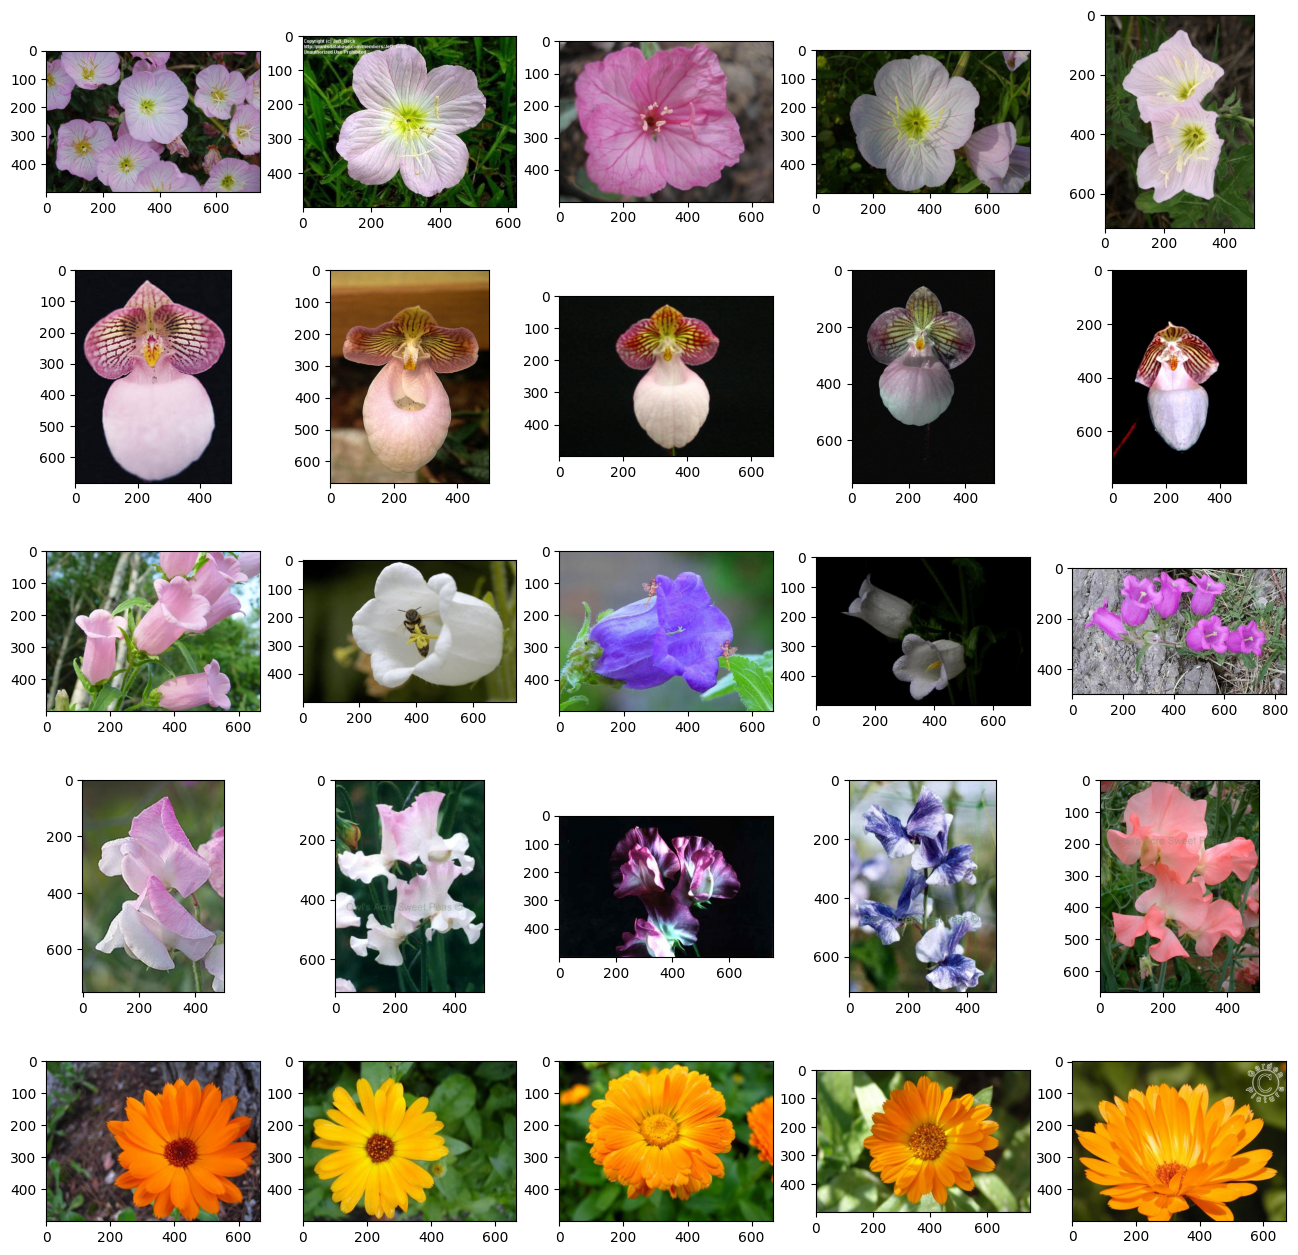

In [16]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(5, 5, figsize=(16,16))

for i in range(5):
    ax[i,0].imshow(samples_train[i][0])
    ax[i,1].imshow(samples_train[i][1])    
    ax[i,2].imshow(samples_train[i][2])    
    ax[i,3].imshow(samples_train[i][3])   
    ax[i,4].imshow(samples_train[i][4])    

### Step 2: Define Siamese Network Architecture

Using the Resnet34 as a backbone for our siamese network and with embeddings of size 64

In [86]:
class TripletNetwork(nn.Module):
    def __init__(self):
        super(TripletNetwork, self).__init__()

        # Initialize base network
        self.base_network = initialize_base_network()
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(2048,102)
        )
        
        self.embedding = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(2048, 64)
        )

    def forward_one(self, x):
        # Forward pass for one branch
        x = self.base_network(x)
        
        classifier = self.classifier(x)
        embedding = self.embedding(x)
        
        return embedding, classifier

    def forward(self, input1, input2, input3):
        # Forward pass for both branches
        embedding_1, classifier_1 = self.forward_one(input1)
        embedding_2, classifier_2 = self.forward_one(input2)
        embedding_3, classifier_3 = self.forward_one(input3)
        
        return embedding_1, embedding_2, embedding_3, classifier_1

def initialize_base_network():
    # Initialize base network (ResNet34 in this case)
    base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    
    # Freeze layers
    for param in base_model.parameters():
        param.requires_grad = False

    # Remove the last two layers (average pooling and fully connected)
    base_model = nn.Sequential(*list(base_model.children())[:-2])

    return base_model

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Compute pairwise distances between anchor and positive, anchor and negative
        distance_positive = F.pairwise_distance(anchor, positive, p=2)
        distance_negative = F.pairwise_distance(anchor, negative, p=2)

        # Compute the triplet loss
        loss = F.relu(distance_positive - distance_negative + self.margin)

        return loss.mean()

### Step 3: Train Siamese Network on samples

In [87]:
# Custom dataset for Siamese network
class SiameseDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = self.convert_dataset(dataset)
        self.transform = transform
    
    def convert_dataset(self, dataset):
        alist = []
        for key in dataset:
            for items in dataset[key]:
                alist.append((items, key))
        return alist
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        anchor, anchor_label = self.dataset[index]

        while True:
            pos_index = random.randint(0, len(self.dataset) - 1)
            pos, pos_label = self.dataset[pos_index]
            if anchor_label == pos_label:
                break

        while True:
            neg_index = random.randint(0, len(self.dataset) - 1)
            neg, neg_label = self.dataset[neg_index]
            if anchor_label != neg_label:
                break
        
        if self.transform:
            anchor = self.transform(anchor)
            pos = self.transform(pos)
            neg = self.transform(neg)
                
        return anchor, pos, neg, anchor_label

In [90]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

train_siamese_dataset = SiameseDataset(samples_train, transform=train_transforms)
train_no_aug_dataset = SiameseDataset(samples_train, transform=test_transforms)
val_siamese_dataset = SiameseDataset(samples_val, transform=test_transforms)
test_siamese_dataset = SiameseDataset(samples_test, transform=test_transforms)


train_siamese_loader = DataLoader(train_siamese_dataset, batch_size=64, shuffle=True)
train_siamese_loader_no_aug = DataLoader(train_no_aug_dataset, batch_size=64, shuffle=True)

val_siamese_loader = DataLoader(val_siamese_dataset, batch_size=64, shuffle=False)
test_siamese_loader = DataLoader(test_siamese_dataset, batch_size=64, shuffle=False)

###### Using Triplet Loss as a regularisation

In [97]:
device='cuda'

# Hyperparameters
learning_rate = 0.001

# Initialize the Siamese network
siamese_net = TripletNetwork().to(device)

# Define a loss function and optimizer
criterion_1 = TripletLoss(margin=1.0)
criterion_2 = nn.CrossEntropyLoss()

optimizer = optim.Adam(siamese_net.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

es = EarlyStopper(patience=8)
# print(siamese_net)

In [98]:
num_epochs = 200

training_loss = []
validation_loss = []

train_trip_loss, val_trip_loss = [], []
train_class_loss, val_class_loss =[] ,[]

training_acc = []
validation_acc = []

best_model_wts = copy.deepcopy(siamese_net.state_dict())
highest_val_acc = -np.inf

for epoch in tqdm(range(num_epochs), desc = 'Epoch'):
    # Training
    siamese_net.train()
    
    total_loss = 0.0
    total_trip_loss =0.0
    total_class_loss = 0.0
    total_correct = 0
    for batch in tqdm(train_siamese_loader_no_aug, desc=f"Epoch {epoch + 1}/ {num_epochs} - Training", leave=False):
        anchor, pos, neg, labels = batch
        anchor, pos, neg, labels = anchor.to(device), pos.to(device), neg.to(device), labels.to(device)

        
        optimizer.zero_grad()
        
        anch_emb, pos_emb, neg_emb, class_logit = siamese_net(anchor, pos, neg)    
        
        _, preds = torch.max(class_logit, 1)
        
        trip_loss = criterion_1(anch_emb, pos_emb, neg_emb)
        classification_loss = criterion_2(class_logit, labels)
        
        comb_loss = trip_loss + classification_loss
        
        comb_loss.backward()
        optimizer.step()

        total_trip_loss += trip_loss.item()
        total_class_loss += classification_loss.item()
        total_loss += comb_loss.item()
        total_correct += torch.sum(preds == labels.data)

    avg_triplet_loss = total_trip_loss / len(train_siamese_loader)
    avg_class_loss = total_class_loss / len(train_siamese_loader)
    avg_loss = total_loss / len(train_siamese_loader)
    train_acc = total_correct.item() / len(train_siamese_dataset.dataset)
    
    
    training_loss.append(avg_loss)
    train_trip_loss.append(avg_triplet_loss)
    train_class_loss.append(avg_class_loss)
    training_acc.append(train_acc)

    # Validation (optional)
    siamese_net.eval()
    with torch.no_grad():
        val_loss = 0.0
        total_loss = 0.0
        total_trip_loss =0.0
        total_class_loss = 0.0
        total_correct = 0
        
        for batch in tqdm(val_siamese_loader, desc=f"Epoch {epoch + 1}/ {num_epochs} - Validation", leave=False):
            anchor, pos, neg, labels = batch
            anchor, pos, neg, labels = anchor.to(device), pos.to(device), neg.to(device), labels.to(device)


            anch_emb, pos_emb, neg_emb, class_logit = siamese_net(anchor, pos, neg)    

            _, preds = torch.max(class_logit, 1)

            trip_loss = criterion_1(anch_emb, pos_emb, neg_emb)
            classification_loss = criterion_2(class_logit, labels)

            comb_loss = trip_loss + classification_loss

            total_trip_loss += trip_loss.item()
            total_class_loss += classification_loss.item()
            total_loss += comb_loss.item()
            total_correct += torch.sum(preds == labels.data)

        val_avg_triplet_loss = total_trip_loss / len(val_siamese_loader)
        val_avg_class_loss = total_class_loss / len(val_siamese_loader)
        val_avg_loss = total_loss / len(val_siamese_loader)
        val_acc = total_correct.item() / len(val_siamese_dataset.dataset)


        validation_loss.append(val_avg_loss)
        val_trip_loss.append(avg_triplet_loss)
        val_class_loss.append(avg_class_loss)
        validation_acc.append(val_acc)
    
    if val_acc > highest_val_acc:
        highest_val_acc = val_acc
        best_model_wts = copy.deepcopy(siamese_net.state_dict())
    
    print(f"""
Epoch {epoch+1}/{num_epochs}-Train Total Loss: {round(avg_loss,3)} ({round(avg_triplet_loss,3)}/{round(avg_class_loss,3)}) Train Acc {round(train_acc*100,2)}% Val Total Loss: {round(val_avg_loss,3)} ({round(val_avg_triplet_loss,3)}/{round(val_avg_class_loss,3)}) Val Acc {round(val_acc*100,2)}% """)
    
    if es.early_stop(val_acc):
        print("Stopping Early")
        break

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 1/200-Train Total Loss: 4.941 (0.48/4.461) Train Acc 11.76% Val Total Loss: 4.429 (0.332/4.096) Val Acc 37.75% 


Epoch 2/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 2/200-Train Total Loss: 3.794 (0.246/3.548) Train Acc 81.96% Val Total Loss: 3.814 (0.23/3.584) Val Acc 65.59% 


Epoch 3/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 3/200-Train Total Loss: 2.985 (0.143/2.842) Train Acc 96.86% Val Total Loss: 3.33 (0.206/3.124) Val Acc 73.43% 


Epoch 4/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 4/200-Train Total Loss: 2.33 (0.132/2.197) Train Acc 98.73% Val Total Loss: 2.967 (0.193/2.773) Val Acc 76.86% 


Epoch 5/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 5/200-Train Total Loss: 1.779 (0.095/1.684) Train Acc 99.61% Val Total Loss: 2.623 (0.168/2.454) Val Acc 77.94% 


Epoch 6/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 6/200-Train Total Loss: 1.432 (0.093/1.34) Train Acc 99.9% Val Total Loss: 2.391 (0.187/2.204) Val Acc 78.73% 


Epoch 7/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 7/200-Train Total Loss: 1.12 (0.068/1.052) Train Acc 100.0% Val Total Loss: 2.209 (0.164/2.045) Val Acc 79.9% 


Epoch 8/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 8/200-Train Total Loss: 0.862 (0.053/0.809) Train Acc 99.9% Val Total Loss: 2.031 (0.162/1.869) Val Acc 80.2% 


Epoch 9/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 9/200-Train Total Loss: 0.707 (0.049/0.658) Train Acc 100.0% Val Total Loss: 1.93 (0.154/1.776) Val Acc 80.69% 


Epoch 10/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 10/200-Train Total Loss: 0.597 (0.058/0.539) Train Acc 100.0% Val Total Loss: 1.819 (0.169/1.65) Val Acc 80.98% 


Epoch 11/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 11/200-Train Total Loss: 0.484 (0.037/0.447) Train Acc 100.0% Val Total Loss: 1.754 (0.164/1.59) Val Acc 81.86% 


Epoch 12/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 12/200-Train Total Loss: 0.424 (0.046/0.378) Train Acc 100.0% Val Total Loss: 1.688 (0.166/1.522) Val Acc 80.88% 


Epoch 13/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 13/200-Train Total Loss: 0.353 (0.031/0.322) Train Acc 100.0% Val Total Loss: 1.661 (0.156/1.505) Val Acc 81.27% 


Epoch 14/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 14/200-Train Total Loss: 0.313 (0.031/0.283) Train Acc 100.0% Val Total Loss: 1.593 (0.157/1.436) Val Acc 81.57% 


Epoch 15/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 15/200-Train Total Loss: 0.277 (0.029/0.249) Train Acc 100.0% Val Total Loss: 1.499 (0.144/1.355) Val Acc 82.45% 


Epoch 16/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 16/200-Train Total Loss: 0.236 (0.026/0.21) Train Acc 100.0% Val Total Loss: 1.479 (0.151/1.328) Val Acc 82.25% 


Epoch 17/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 17/200-Train Total Loss: 0.225 (0.022/0.202) Train Acc 100.0% Val Total Loss: 1.414 (0.137/1.277) Val Acc 82.55% 


Epoch 18/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 18/200-Train Total Loss: 0.198 (0.019/0.178) Train Acc 100.0% Val Total Loss: 1.4 (0.139/1.261) Val Acc 82.35% 


Epoch 19/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 19/200-Train Total Loss: 0.187 (0.029/0.158) Train Acc 100.0% Val Total Loss: 1.409 (0.165/1.243) Val Acc 82.65% 


Epoch 20/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 20/200-Train Total Loss: 0.155 (0.018/0.138) Train Acc 100.0% Val Total Loss: 1.37 (0.169/1.201) Val Acc 82.45% 


Epoch 21/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 21/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 21/200-Train Total Loss: 0.147 (0.022/0.125) Train Acc 100.0% Val Total Loss: 1.362 (0.151/1.211) Val Acc 82.35% 


Epoch 22/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 22/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 22/200-Train Total Loss: 0.141 (0.023/0.118) Train Acc 100.0% Val Total Loss: 1.339 (0.143/1.196) Val Acc 82.35% 


Epoch 23/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 23/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 23/200-Train Total Loss: 0.122 (0.013/0.109) Train Acc 100.0% Val Total Loss: 1.304 (0.131/1.173) Val Acc 82.55% 


Epoch 24/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 24/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 24/200-Train Total Loss: 0.114 (0.013/0.101) Train Acc 100.0% Val Total Loss: 1.285 (0.151/1.134) Val Acc 83.14% 


Epoch 25/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 25/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 25/200-Train Total Loss: 0.115 (0.013/0.102) Train Acc 100.0% Val Total Loss: 1.275 (0.15/1.125) Val Acc 82.16% 


Epoch 26/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 26/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 26/200-Train Total Loss: 0.103 (0.011/0.092) Train Acc 100.0% Val Total Loss: 1.25 (0.132/1.118) Val Acc 82.45% 


Epoch 27/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 27/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 27/200-Train Total Loss: 0.104 (0.022/0.082) Train Acc 100.0% Val Total Loss: 1.258 (0.149/1.109) Val Acc 82.94% 


Epoch 28/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 28/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 28/200-Train Total Loss: 0.086 (0.013/0.073) Train Acc 100.0% Val Total Loss: 1.236 (0.14/1.096) Val Acc 82.35% 


Epoch 29/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 29/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 29/200-Train Total Loss: 0.086 (0.014/0.072) Train Acc 100.0% Val Total Loss: 1.247 (0.168/1.079) Val Acc 82.35% 


Epoch 30/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 30/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 30/200-Train Total Loss: 0.079 (0.015/0.063) Train Acc 100.0% Val Total Loss: 1.186 (0.145/1.041) Val Acc 82.55% 


Epoch 31/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 31/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 31/200-Train Total Loss: 0.072 (0.01/0.062) Train Acc 100.0% Val Total Loss: 1.213 (0.155/1.058) Val Acc 82.45% 


Epoch 32/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 32/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 32/200-Train Total Loss: 0.074 (0.01/0.064) Train Acc 100.0% Val Total Loss: 1.163 (0.126/1.037) Val Acc 83.14% 


Epoch 33/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 33/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 33/200-Train Total Loss: 0.067 (0.012/0.055) Train Acc 100.0% Val Total Loss: 1.185 (0.166/1.019) Val Acc 83.04% 
Stopping Early


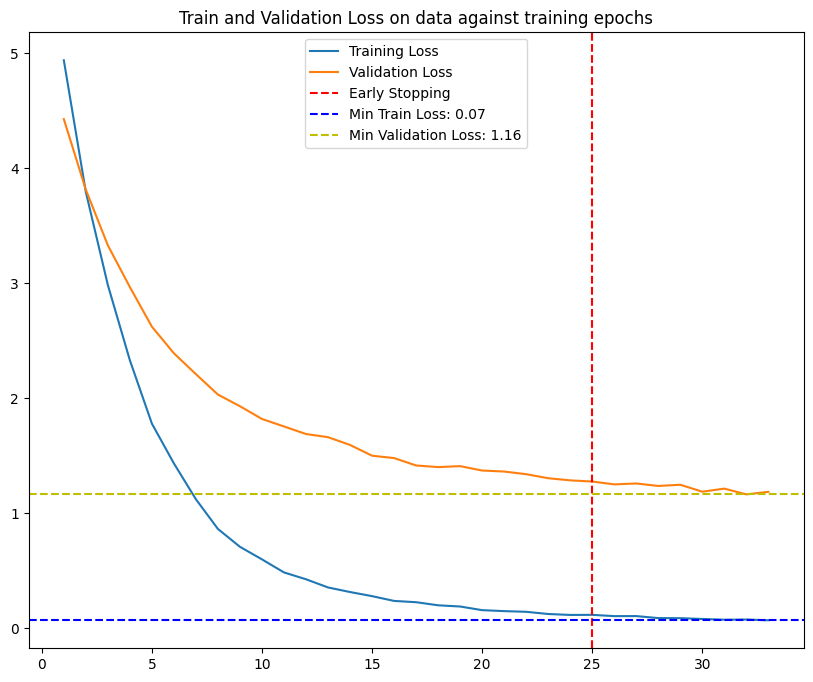

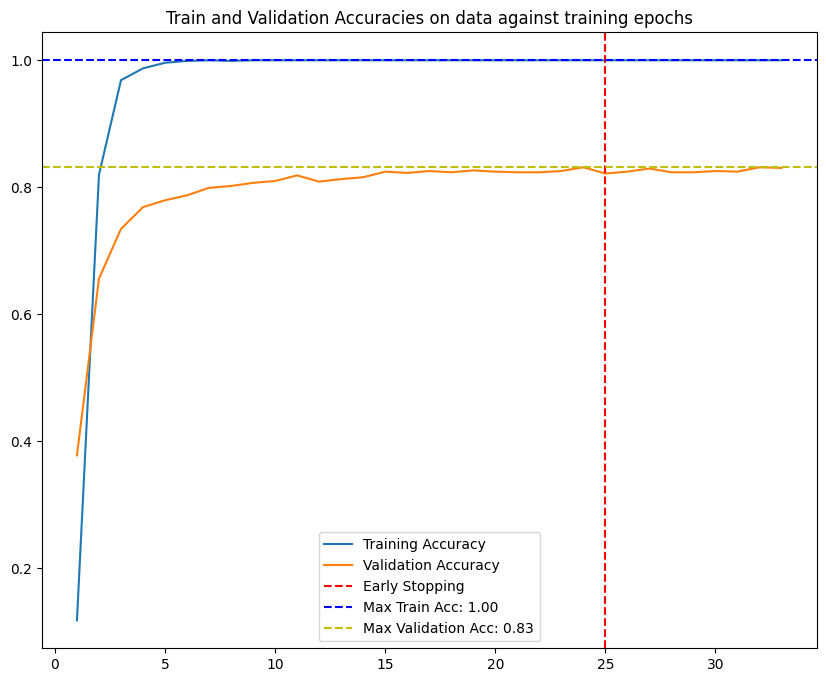

In [99]:
early_stopping_epoch = len(training_loss)-8
min_train_loss = min(training_loss)
min_test_loss = min(validation_loss)
max_train_accuracy = max(training_acc)
max_test_accuracy = max(validation_acc)

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Loss on data against training epochs')
plt.plot(range(1,len(training_loss)+1),training_loss, label='Training Loss')
plt.plot(range(1,len(validation_loss)+1),validation_loss,label='Validation Loss')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=min_train_loss, color='b', linestyle='--', label=f'Min Train Loss: {min_train_loss:.2f}')
plt.axhline(y=min_test_loss, color='y', linestyle='--', label=f'Min Validation Loss: {min_test_loss:.2f}')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Accuracies on data against training epochs')
plt.plot(range(1,len(training_acc)+1),training_acc, label='Training Accuracy')
plt.plot(range(1,len(validation_acc)+1),validation_acc, label='Validation Accuracy')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=max_train_accuracy, color='b', linestyle='--', label=f'Max Train Acc: {max_train_accuracy:.2f}')
plt.axhline(y=max_test_accuracy, color='y', linestyle='--', label=f'Max Validation Acc: {max_test_accuracy:.2f}')
plt.legend()
plt.show()

In [107]:
y_true, y_pred = [], []

siamese_net.load_state_dict(best_model_wts)

siamese_net.eval()
total_correct = 0.0
with torch.no_grad():
    for batch in tqdm(test_siamese_loader, desc="Test", leave=False):
        anchor, pos, neg, labels = batch
        anchor, pos, neg, labels = anchor.to(device), pos.to(device), neg.to(device), labels.to(device)

        anch_emb, pos_emb, neg_emb, class_logit = siamese_net(anchor, pos, neg)    

        _, preds = torch.max(class_logit, 1)

        total_correct += torch.sum(preds == labels.data)
        
        y_true += labels.tolist()
        y_pred += preds.tolist()

test_acc = total_correct/len(test_siamese_loader.dataset)
test_f1 = f1_score(y_true, y_pred, average='weighted')

print(f"""
Test Acc: {test_acc}
Test F1: {test_f1}
""")

Test:   0%|          | 0/97 [00:00<?, ?it/s]


Test Acc: 0.8133029937744141
Test F1: 0.8111014611428377



In [112]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.75      0.63        20
           1       0.94      0.85      0.89        40
           2       0.25      0.35      0.29        20
           3       0.44      0.44      0.44        36
           4       0.72      0.87      0.79        45
           5       0.82      0.92      0.87        25
           6       0.70      0.95      0.81        20
           7       0.86      1.00      0.92        65
           8       0.81      0.96      0.88        26
           9       0.92      0.92      0.92        25
          10       0.78      0.60      0.68        67
          11       0.85      0.91      0.88        67
          12       0.76      0.97      0.85        29
          13       0.68      1.00      0.81        28
          14       0.80      0.83      0.81        29
          15       0.62      0.71      0.67        21
          16       0.91      0.91      0.91        65
          17       0.60    

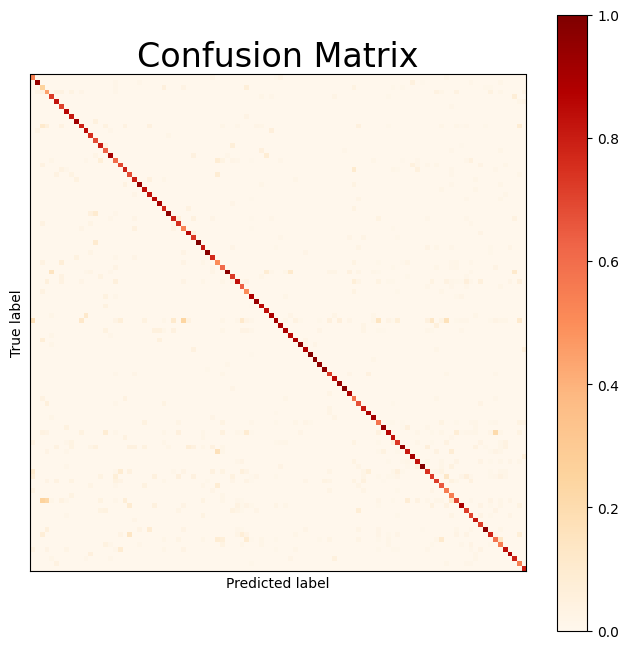

In [113]:
c_m = confusion_matrix(y_true, y_pred, normalize='pred')

plt.rcParams['figure.figsize'] = (8, 8)
display_c_m = ConfusionMatrixDisplay(c_m)
display_c_m.plot(cmap='OrRd', include_values=False)

plt.title('Confusion Matrix', fontsize=24)

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# Showing the plot
plt.show()

###### With data augmentation

In [110]:
device='cuda'

# Hyperparameters
learning_rate = 0.001

# Initialize the Siamese network
siamese_net = TripletNetwork().to(device)

# Define a loss function and optimizer
criterion_1 = TripletLoss(margin=1.0)
criterion_2 = nn.CrossEntropyLoss()

optimizer = optim.Adam(siamese_net.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

es = EarlyStopper(patience=8)
# print(siamese_net)

In [111]:
num_epochs = 200

training_loss = []
validation_loss = []

train_trip_loss, val_trip_loss = [], []
train_class_loss, val_class_loss =[] ,[]

training_acc = []
validation_acc = []

best_model_wts = copy.deepcopy(siamese_net.state_dict())
highest_val_acc = -np.inf

for epoch in tqdm(range(num_epochs), desc = 'Epoch'):
    # Training
    siamese_net.train()
    
    total_loss = 0.0
    total_trip_loss =0.0
    total_class_loss = 0.0
    total_correct = 0
    for batch in tqdm(train_siamese_loader, desc=f"Epoch {epoch + 1}/ {num_epochs} - Training", leave=False):
        anchor, pos, neg, labels = batch
        anchor, pos, neg, labels = anchor.to(device), pos.to(device), neg.to(device), labels.to(device)

        
        optimizer.zero_grad()
        
        anch_emb, pos_emb, neg_emb, class_logit = siamese_net(anchor, pos, neg)    
        
        _, preds = torch.max(class_logit, 1)
        
        trip_loss = criterion_1(anch_emb, pos_emb, neg_emb)
        classification_loss = criterion_2(class_logit, labels)
        
        comb_loss = trip_loss + classification_loss
        
        comb_loss.backward()
        optimizer.step()

        total_trip_loss += trip_loss.item()
        total_class_loss += classification_loss.item()
        total_loss += comb_loss.item()
        total_correct += torch.sum(preds == labels.data)

    avg_triplet_loss = total_trip_loss / len(train_siamese_loader)
    avg_class_loss = total_class_loss / len(train_siamese_loader)
    avg_loss = total_loss / len(train_siamese_loader)
    train_acc = total_correct.item() / len(train_siamese_dataset.dataset)
    
    
    training_loss.append(avg_loss)
    train_trip_loss.append(avg_triplet_loss)
    train_class_loss.append(avg_class_loss)
    training_acc.append(train_acc)

    # Validation (optional)
    siamese_net.eval()
    with torch.no_grad():
        val_loss = 0.0
        total_loss = 0.0
        total_trip_loss =0.0
        total_class_loss = 0.0
        total_correct = 0
        
        for batch in tqdm(val_siamese_loader, desc=f"Epoch {epoch + 1}/ {num_epochs} - Validation", leave=False):
            anchor, pos, neg, labels = batch
            anchor, pos, neg, labels = anchor.to(device), pos.to(device), neg.to(device), labels.to(device)


            anch_emb, pos_emb, neg_emb, class_logit = siamese_net(anchor, pos, neg)    

            _, preds = torch.max(class_logit, 1)

            trip_loss = criterion_1(anch_emb, pos_emb, neg_emb)
            classification_loss = criterion_2(class_logit, labels)

            comb_loss = trip_loss + classification_loss

            total_trip_loss += trip_loss.item()
            total_class_loss += classification_loss.item()
            total_loss += comb_loss.item()
            total_correct += torch.sum(preds == labels.data)

        val_avg_triplet_loss = total_trip_loss / len(val_siamese_loader)
        val_avg_class_loss = total_class_loss / len(val_siamese_loader)
        val_avg_loss = total_loss / len(val_siamese_loader)
        val_acc = total_correct.item() / len(val_siamese_dataset.dataset)


        validation_loss.append(val_avg_loss)
        val_trip_loss.append(avg_triplet_loss)
        val_class_loss.append(avg_class_loss)
        validation_acc.append(val_acc)
    
    if val_acc > highest_val_acc:
        highest_val_acc = val_acc
        best_model_wts = copy.deepcopy(siamese_net.state_dict())
    
    print(f"""
Epoch {epoch+1}/{num_epochs}-Train Total Loss: {round(avg_loss,3)} ({round(avg_triplet_loss,3)}/{round(avg_class_loss,3)}) Train Acc {round(train_acc*100,2)}% Val Total Loss: {round(val_avg_loss,3)} ({round(val_avg_triplet_loss,3)}/{round(val_avg_class_loss,3)}) Val Acc {round(val_acc*100,2)}% """)
    
    if es.early_stop(val_acc):
        print("Stopping Early")
        break

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 1/200-Train Total Loss: 5.196 (0.667/4.529) Train Acc 5.59% Val Total Loss: 4.589 (0.402/4.187) Val Acc 22.16% 


Epoch 2/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 2/200-Train Total Loss: 4.303 (0.4/3.903) Train Acc 45.88% Val Total Loss: 4.073 (0.3/3.773) Val Acc 54.71% 


Epoch 3/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 3/200-Train Total Loss: 3.763 (0.321/3.442) Train Acc 71.08% Val Total Loss: 3.617 (0.237/3.381) Val Acc 67.25% 


Epoch 4/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 4/200-Train Total Loss: 3.238 (0.235/3.002) Train Acc 78.82% Val Total Loss: 3.267 (0.217/3.05) Val Acc 70.49% 


Epoch 5/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 5/200-Train Total Loss: 2.846 (0.216/2.63) Train Acc 83.33% Val Total Loss: 3.02 (0.227/2.793) Val Acc 72.16% 


Epoch 6/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 6/200-Train Total Loss: 2.508 (0.213/2.295) Train Acc 85.88% Val Total Loss: 2.752 (0.209/2.543) Val Acc 74.22% 


Epoch 7/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 7/200-Train Total Loss: 2.278 (0.226/2.052) Train Acc 85.59% Val Total Loss: 2.527 (0.198/2.329) Val Acc 76.18% 


Epoch 8/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 8/200-Train Total Loss: 2.03 (0.217/1.812) Train Acc 88.92% Val Total Loss: 2.363 (0.205/2.157) Val Acc 75.39% 


Epoch 9/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 9/200-Train Total Loss: 1.864 (0.211/1.653) Train Acc 89.31% Val Total Loss: 2.204 (0.162/2.042) Val Acc 75.49% 


Epoch 10/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 10/200-Train Total Loss: 1.708 (0.194/1.514) Train Acc 89.22% Val Total Loss: 2.081 (0.186/1.895) Val Acc 76.18% 


Epoch 11/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 11/200-Train Total Loss: 1.572 (0.183/1.388) Train Acc 90.88% Val Total Loss: 1.959 (0.177/1.781) Val Acc 77.25% 


Epoch 12/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 12/200-Train Total Loss: 1.437 (0.168/1.269) Train Acc 91.08% Val Total Loss: 1.904 (0.178/1.725) Val Acc 78.04% 


Epoch 13/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 13/200-Train Total Loss: 1.335 (0.157/1.178) Train Acc 91.37% Val Total Loss: 1.773 (0.149/1.624) Val Acc 78.24% 


Epoch 14/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 14/200-Train Total Loss: 1.241 (0.164/1.077) Train Acc 90.69% Val Total Loss: 1.745 (0.181/1.565) Val Acc 78.92% 


Epoch 15/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 15/200-Train Total Loss: 1.165 (0.181/0.984) Train Acc 92.65% Val Total Loss: 1.619 (0.159/1.46) Val Acc 79.12% 


Epoch 16/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 16/200-Train Total Loss: 1.055 (0.161/0.894) Train Acc 92.75% Val Total Loss: 1.587 (0.155/1.432) Val Acc 79.71% 


Epoch 17/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 17/200-Train Total Loss: 0.986 (0.136/0.85) Train Acc 95.0% Val Total Loss: 1.525 (0.166/1.36) Val Acc 80.59% 


Epoch 18/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 18/200-Train Total Loss: 0.917 (0.143/0.774) Train Acc 94.51% Val Total Loss: 1.469 (0.151/1.318) Val Acc 80.39% 


Epoch 19/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 19/200-Train Total Loss: 0.882 (0.118/0.764) Train Acc 94.22% Val Total Loss: 1.434 (0.148/1.286) Val Acc 81.67% 


Epoch 20/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 20/200-Train Total Loss: 0.839 (0.145/0.694) Train Acc 95.0% Val Total Loss: 1.407 (0.13/1.277) Val Acc 80.39% 


Epoch 21/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 21/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 21/200-Train Total Loss: 0.775 (0.105/0.671) Train Acc 94.41% Val Total Loss: 1.39 (0.161/1.229) Val Acc 80.78% 


Epoch 22/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 22/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 22/200-Train Total Loss: 0.76 (0.124/0.636) Train Acc 95.2% Val Total Loss: 1.36 (0.147/1.213) Val Acc 81.76% 


Epoch 23/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 23/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 23/200-Train Total Loss: 0.746 (0.143/0.603) Train Acc 95.29% Val Total Loss: 1.294 (0.134/1.16) Val Acc 81.76% 


Epoch 24/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 24/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 24/200-Train Total Loss: 0.751 (0.159/0.592) Train Acc 94.71% Val Total Loss: 1.248 (0.144/1.104) Val Acc 82.55% 


Epoch 25/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 25/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 25/200-Train Total Loss: 0.651 (0.105/0.546) Train Acc 96.76% Val Total Loss: 1.269 (0.161/1.108) Val Acc 81.37% 


Epoch 26/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 26/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 26/200-Train Total Loss: 0.707 (0.142/0.565) Train Acc 95.29% Val Total Loss: 1.222 (0.157/1.064) Val Acc 82.65% 


Epoch 27/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 27/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 27/200-Train Total Loss: 0.635 (0.146/0.489) Train Acc 95.98% Val Total Loss: 1.239 (0.168/1.07) Val Acc 81.67% 


Epoch 28/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 28/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 28/200-Train Total Loss: 0.654 (0.146/0.509) Train Acc 95.39% Val Total Loss: 1.185 (0.125/1.059) Val Acc 81.67% 


Epoch 29/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 29/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 29/200-Train Total Loss: 0.62 (0.138/0.482) Train Acc 95.49% Val Total Loss: 1.196 (0.145/1.05) Val Acc 81.67% 


Epoch 30/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 30/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 30/200-Train Total Loss: 0.609 (0.099/0.51) Train Acc 95.1% Val Total Loss: 1.155 (0.147/1.008) Val Acc 82.35% 


Epoch 31/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 31/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 31/200-Train Total Loss: 0.538 (0.1/0.438) Train Acc 95.88% Val Total Loss: 1.139 (0.148/0.99) Val Acc 81.96% 


Epoch 32/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 32/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 32/200-Train Total Loss: 0.557 (0.13/0.428) Train Acc 95.59% Val Total Loss: 1.088 (0.109/0.979) Val Acc 82.45% 


Epoch 33/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 33/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 33/200-Train Total Loss: 0.586 (0.129/0.457) Train Acc 94.31% Val Total Loss: 1.079 (0.136/0.943) Val Acc 82.45% 


Epoch 34/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 34/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 34/200-Train Total Loss: 0.496 (0.104/0.393) Train Acc 96.27% Val Total Loss: 1.088 (0.147/0.941) Val Acc 83.33% 


Epoch 35/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 35/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 35/200-Train Total Loss: 0.494 (0.093/0.401) Train Acc 96.27% Val Total Loss: 1.086 (0.139/0.947) Val Acc 83.04% 


Epoch 36/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 36/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 36/200-Train Total Loss: 0.509 (0.105/0.404) Train Acc 95.78% Val Total Loss: 1.052 (0.135/0.917) Val Acc 82.55% 


Epoch 37/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 37/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 37/200-Train Total Loss: 0.508 (0.104/0.405) Train Acc 95.98% Val Total Loss: 1.03 (0.13/0.901) Val Acc 83.14% 


Epoch 38/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 38/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 38/200-Train Total Loss: 0.437 (0.094/0.343) Train Acc 96.37% Val Total Loss: 1.069 (0.135/0.934) Val Acc 82.16% 


Epoch 39/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 39/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 39/200-Train Total Loss: 0.459 (0.108/0.351) Train Acc 96.76% Val Total Loss: 1.048 (0.16/0.887) Val Acc 83.53% 


Epoch 40/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 40/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 40/200-Train Total Loss: 0.42 (0.088/0.332) Train Acc 96.08% Val Total Loss: 0.98 (0.109/0.871) Val Acc 83.24% 


Epoch 41/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 41/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 41/200-Train Total Loss: 0.438 (0.104/0.333) Train Acc 96.47% Val Total Loss: 1.0 (0.132/0.868) Val Acc 83.43% 


Epoch 42/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 42/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 42/200-Train Total Loss: 0.421 (0.103/0.318) Train Acc 96.76% Val Total Loss: 0.986 (0.129/0.857) Val Acc 83.33% 


Epoch 43/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 43/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 43/200-Train Total Loss: 0.427 (0.102/0.325) Train Acc 96.37% Val Total Loss: 1.0 (0.151/0.849) Val Acc 83.24% 


Epoch 44/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 44/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 44/200-Train Total Loss: 0.407 (0.096/0.311) Train Acc 96.47% Val Total Loss: 0.997 (0.142/0.855) Val Acc 83.14% 


Epoch 45/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 45/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 45/200-Train Total Loss: 0.411 (0.105/0.306) Train Acc 96.18% Val Total Loss: 0.948 (0.122/0.826) Val Acc 83.92% 


Epoch 46/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 46/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 46/200-Train Total Loss: 0.398 (0.106/0.292) Train Acc 97.25% Val Total Loss: 0.982 (0.131/0.851) Val Acc 82.35% 


Epoch 47/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 47/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 47/200-Train Total Loss: 0.399 (0.1/0.299) Train Acc 96.67% Val Total Loss: 0.935 (0.128/0.807) Val Acc 84.02% 


Epoch 48/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 48/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 48/200-Train Total Loss: 0.37 (0.096/0.273) Train Acc 96.96% Val Total Loss: 0.947 (0.13/0.817) Val Acc 83.82% 


Epoch 49/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 49/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 49/200-Train Total Loss: 0.375 (0.096/0.28) Train Acc 96.27% Val Total Loss: 0.921 (0.113/0.807) Val Acc 83.04% 


Epoch 50/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 50/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 50/200-Train Total Loss: 0.376 (0.076/0.3) Train Acc 96.86% Val Total Loss: 0.944 (0.138/0.806) Val Acc 83.33% 


Epoch 51/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 51/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 51/200-Train Total Loss: 0.342 (0.092/0.25) Train Acc 97.06% Val Total Loss: 0.954 (0.152/0.802) Val Acc 83.53% 


Epoch 52/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 52/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 52/200-Train Total Loss: 0.355 (0.092/0.263) Train Acc 97.06% Val Total Loss: 0.94 (0.138/0.802) Val Acc 83.43% 


Epoch 53/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 53/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 53/200-Train Total Loss: 0.364 (0.104/0.259) Train Acc 97.16% Val Total Loss: 0.902 (0.12/0.782) Val Acc 83.63% 


Epoch 54/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 54/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 54/200-Train Total Loss: 0.342 (0.093/0.249) Train Acc 97.75% Val Total Loss: 0.906 (0.121/0.785) Val Acc 82.94% 


Epoch 55/ 200 - Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 55/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 55/200-Train Total Loss: 0.325 (0.091/0.234) Train Acc 97.65% Val Total Loss: 0.908 (0.131/0.777) Val Acc 83.73% 
Stopping Early


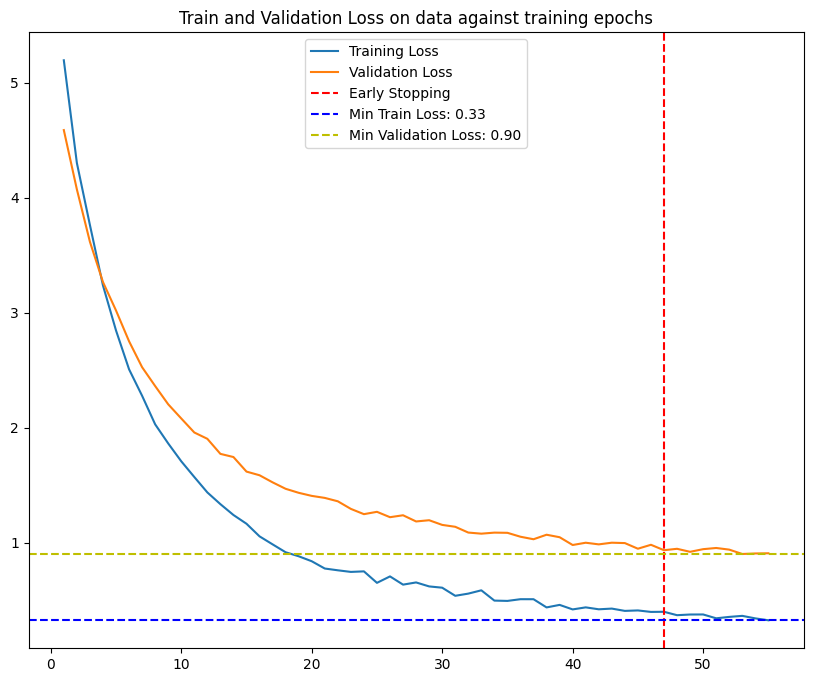

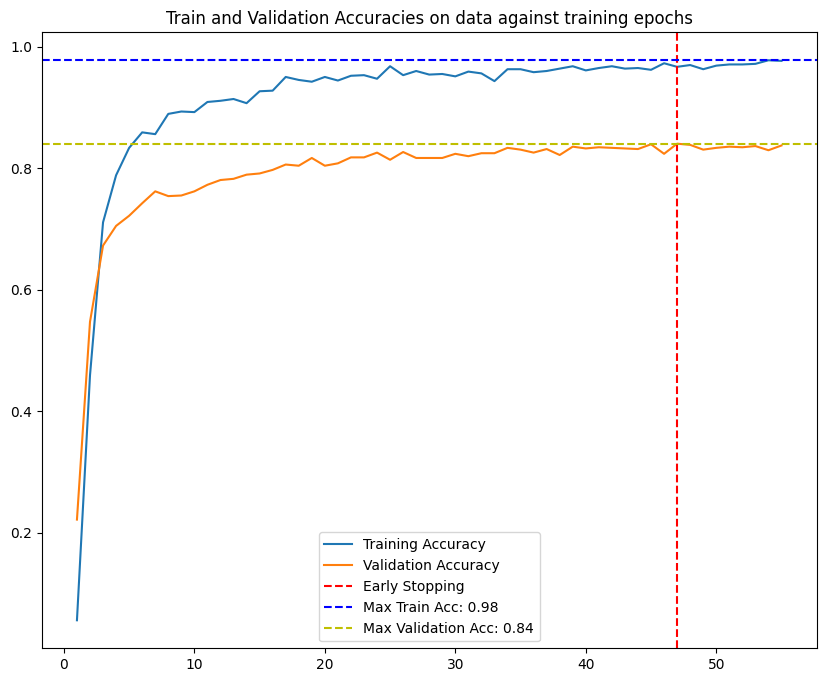

In [114]:
early_stopping_epoch = len(training_loss)-8
min_train_loss = min(training_loss)
min_test_loss = min(validation_loss)
max_train_accuracy = max(training_acc)
max_test_accuracy = max(validation_acc)

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Loss on data against training epochs')
plt.plot(range(1,len(training_loss)+1),training_loss, label='Training Loss')
plt.plot(range(1,len(validation_loss)+1),validation_loss,label='Validation Loss')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=min_train_loss, color='b', linestyle='--', label=f'Min Train Loss: {min_train_loss:.2f}')
plt.axhline(y=min_test_loss, color='y', linestyle='--', label=f'Min Validation Loss: {min_test_loss:.2f}')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Accuracies on data against training epochs')
plt.plot(range(1,len(training_acc)+1),training_acc, label='Training Accuracy')
plt.plot(range(1,len(validation_acc)+1),validation_acc, label='Validation Accuracy')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=max_train_accuracy, color='b', linestyle='--', label=f'Max Train Acc: {max_train_accuracy:.2f}')
plt.axhline(y=max_test_accuracy, color='y', linestyle='--', label=f'Max Validation Acc: {max_test_accuracy:.2f}')
plt.legend()
plt.show()

In [115]:
y_true, y_pred = [], []

siamese_net.load_state_dict(best_model_wts)

siamese_net.eval()
total_correct = 0.0
with torch.no_grad():
    for batch in tqdm(test_siamese_loader, desc="Test", leave=False):
        anchor, pos, neg, labels = batch
        anchor, pos, neg, labels = anchor.to(device), pos.to(device), neg.to(device), labels.to(device)

        anch_emb, pos_emb, neg_emb, class_logit = siamese_net(anchor, pos, neg)    

        _, preds = torch.max(class_logit, 1)

        total_correct += torch.sum(preds == labels.data)
        
        y_true += labels.tolist()
        y_pred += preds.tolist()

test_acc = total_correct/len(test_siamese_loader.dataset)
test_f1 = f1_score(y_true, y_pred, average='weighted')

print(f"""
Test Acc: {test_acc}
Test F1: {test_f1}
""")

Test:   0%|          | 0/97 [00:00<?, ?it/s]


Test Acc: 0.8292405605316162
Test F1: 0.8289376373299517



In [116]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.80      0.65        20
           1       1.00      0.88      0.93        40
           2       0.29      0.45      0.35        20
           3       0.75      0.42      0.54        36
           4       0.83      0.78      0.80        45
           5       0.86      1.00      0.93        25
           6       0.70      0.95      0.81        20
           7       0.94      1.00      0.97        65
           8       0.75      0.81      0.78        26
           9       0.89      0.96      0.92        25
          10       0.93      0.60      0.73        67
          11       0.95      0.84      0.89        67
          12       0.93      0.86      0.89        29
          13       0.80      1.00      0.89        28
          14       0.70      0.97      0.81        29
          15       0.57      0.57      0.57        21
          16       0.95      0.92      0.94        65
          17       0.70    

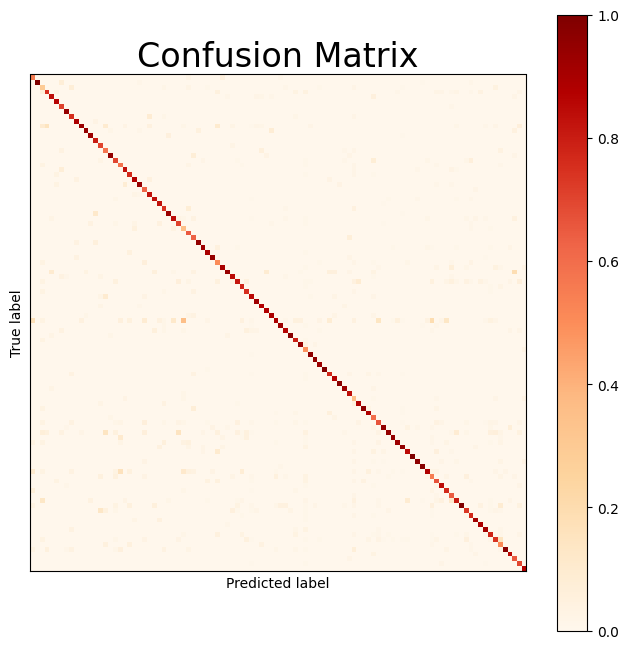

In [117]:
c_m = confusion_matrix(y_true, y_pred, normalize='pred')

plt.rcParams['figure.figsize'] = (8, 8)
display_c_m = ConfusionMatrixDisplay(c_m)
display_c_m.plot(cmap='OrRd', include_values=False)

plt.title('Confusion Matrix', fontsize=24)

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# Showing the plot
plt.show()